# Practical SQL: Chapter Practice Notebook

This Jupyter notebook will display all SQL queries and practices covered in each chapter of the book "Practical SQL: A Beginner's Guide To Storytelling With Data" by Anthony DeBarros.

The first part of this notebook will require us to import a couple of dependencies as well as personal data that will allow us to link out Jupyter Notebook to PostgreSQL.

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from sql_data import db, usr, pwd

In [2]:
# Connecting to postgreSQL database
conn = psycopg2.connect(
    host = "localhost",
    database = db,
    user = usr,
    password = pwd,
    port = 5432
)

def execute_query(connection, query):
    connection.autocommit = True
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        results = cursor.fetchall()
        column_names = [i[0] for i in cursor.description]
        results = pd.DataFrame(results, columns= column_names)
        return results
        return print("Query executed succesfully!")
        # Closing the cursor
        cursor.close()
        del cursor
        # Closing the connection
        connection.close()
    except OperationalError as e:
        print(f"The error '{e}' occurred.")

## Chapter 8: Extracting Information By Grouping and Summarizing

This chapter requires us to build two tables based on the 2009 and 2014 Public Library Surveys conducted by the Institute of Museum and Library Services (IMLS). Please refer to the books resources as detailed in the readme page to gain access to the csv files needed to fill in the two library tables used henceforth.

In [3]:
# Exploring the Library Data Using Aggregate Functions
# Counting Rows and Values using Count()

query = """
SELECT COUNT(*)
FROM pls_fy2014_pupld14a;
"""

execute_query(conn, query)

,count
0,9305


In [4]:
query = """
SELECT COUNT(*)
FROM pls_fy2009_pupld09a;
"""

execute_query(conn, query)

,count
0,9299


In [5]:
# Examining the count of rows in columns where the NOT NULL constraint was not applied
query = """
SELECT COUNT(salaries)
FROM pls_fy2014_pupld14a;
"""
execute_query(conn,query)

,count
0,5983


In [6]:
# Using the DISTINCT function to see how many unique values are contained within a column
# This query returns the count of all rows
query = """
SELECT COUNT(libname)
FROM pls_fy2014_pupld14a;
"""
execute_query(conn,query)

,count
0,9305


In [7]:
# This query return the unique values of the same column. The number should be smaller as there are some duplicated values.
query = """
SELECT COUNT(DISTINCT(libname))
FROM pls_fy2014_pupld14a;
"""
execute_query(conn,query)

,count
0,8515


In [8]:
# Finding Maximum and Minimum Values Using MAX() and MIN()
query = """
SELECT MAX(visits), MIN(visits)
FROM pls_fy2014_pupld14a;
"""
execute_query(conn, query)

,max,min
0,17729020,-3


In [9]:
# Aggregating Data Using GROUP BY

# Combining GROUP BY clause with COUNT()
query = """
SELECT stabr, COUNT(*)
FROM pls_fy2014_pupld14a
GROUP BY stabr
ORDER BY COUNT(*) DESC
LIMIT 5;
"""
execute_query(conn, query)

,stabr,count
0,NY,756
1,IL,625
2,TX,556
3,IA,543
4,PA,455


In [10]:
# Aggregating data from multiple columns using GROUP BY
query = """
SELECT stabr, stataddr, COUNT(*)
FROM pls_fy2014_pupld14a
GROUP BY stabr, stataddr
ORDER BY stabr ASC, COUNT(*) DESC;
"""

execute_query(conn, query)

,stabr,stataddr,count
0,AK,00,70
1,AK,15,10
2,AK,07,5
3,AL,00,221
4,AL,07,3
...,...,...,...
101,WI,07,6
102,WI,15,3
103,WV,00,93
104,WV,15,4


In [11]:
# Aggregating data from multiple joined tables

# No aggregation but here we are trying to determine trends in library visists using the 2014 and 2009 tables 
query = """
SELECT SUM(pls14.visits) AS visits_2014,
    SUM(pls09.visits) AS visits_2009
FROM pls_fy2014_pupld14a AS pls14
JOIN pls_fy2009_pupld09a AS pls09
    ON pls14.fscskey = pls09.fscskey
WHERE pls14.visits >=0 AND pls09.visits >= 0;
"""

execute_query(conn, query)

,visits_2014,visits_2009
0,1417299241,1585455205


In [12]:
# Aggregating data to compare trends by states
query = """
SELECT
    pls14.stabr,
    SUM(pls14.visits) AS visits_2014,
    SUM(pls09.visits) AS visits_2009,
    ROUND( (CAST(SUM(pls14.visits) AS DECIMAL(10, 1)) - SUM(pls09.visits)) /
        SUM(pls09.visits) * 100, 2) AS pct_change
FROM pls_fy2014_pupld14a AS pls14
JOIN pls_fy2009_pupld09a AS pls09
    ON pls14.fscskey = pls09.fscskey
WHERE pls14.visits >=0 AND pls09.visits >= 0
GROUP BY pls14.stabr
ORDER BY pct_change DESC
LIMIT 5
;
"""

execute_query(conn, query)

,stabr,visits_2014,visits_2009,pct_change
0,GU,103593,60763,70.49
1,DC,4230790,2944774,43.67
2,LA,17242110,15591805,10.58
3,MT,4582604,4386504,4.47
4,AL,17113602,16933967,1.06


In [13]:
# Filtering an Aggregate Query Using Having
query = """
SELECT
    pls14.stabr,
    SUM(pls14.visits) AS visits_2014,
    SUM(pls09.visits) AS visits_2009,
    ROUND( (CAST(SUM(pls14.visits) AS DECIMAL(10, 1)) - SUM(pls09.visits)) /
        SUM(pls09.visits) * 100, 2) AS pct_change
FROM pls_fy2014_pupld14a AS pls14
JOIN pls_fy2009_pupld09a AS pls09
    ON pls14.fscskey = pls09.fscskey
WHERE pls14.visits >=0 AND pls09.visits >= 0
GROUP BY pls14.stabr
HAVING SUM(pls14.visits) > 50000000
ORDER BY pct_change DESC
LIMIT 5
;
"""

execute_query(conn, query)

,stabr,visits_2014,visits_2009,pct_change
0,TX,72876601,78838400,-7.56
1,CA,162787836,182181408,-10.65
2,OH,82495138,92402369,-10.72
3,NY,106453546,119810969,-11.15
4,IL,72598213,82438755,-11.94


## Chapter 9: Inspecting and Modifying Data

For this chaper, we will use a direcory of U.S. meat, poultry, and egg producers provided by the Food Safety and Inspection Service (FSIS)  agency within the U.S. Department of Agriculture.

These first initial queries should give us some insight into our dataset:

In [14]:
# Reviweing our imported data
query = """
SELECT COUNT(*)
FROM meat_poultry_egg_inspect;
"""

execute_query(conn, query)

,count
0,6201


In [15]:
# Looking for duplicates
query = """
SELECT company,
    street,
    city,
    st,
    COUNT(*) AS address_count
FROM meat_poultry_egg_inspect
GROUP BY company, street, city, st
HAVING COUNT(*) > 1
ORDER BY company, street, city, st;
"""

execute_query(conn, query)

,company,street,city,st,address_count
0,Acre Station Meat Farm,17076 Hwy 32 N,Pinetown,NC,2
1,Beltex Corporation,3801 North Grove Street,Fort Worth,TX,2
2,Cloverleaf Cold Storage,111 Imperial Drive,Sanford,NC,2
3,"Crete Core Ingredients, LLC",2220 County Road I,Crete,NE,2
4,"Crider, Inc.",1 Plant Avenue,Stillmore,GA,3
5,"Dimension Marketing & Sales, Inc.",386 West 9400 South,Sandy,UT,2
6,"Foster Poultry Farms, A California Corporation",6648 Highway 15 North,Farmerville,LA,2
7,"Freezer & Dry Storage, LLC",21740 Trolley Industrial Drive,Taylor,MI,2
8,JBS Souderton Inc.,249 Allentown Road,Souderton,PA,2
9,KB Poultry Processing LLC,15024 Sandstone Dr.,Utica,MN,2


In [16]:
# Checking for missing values
query = """
SELECT st,
    COUNT(*) AS state_count
FROM meat_poultry_egg_inspect
GROUP BY st
ORDER BY st NULLS FIRST
LIMIT 10
"""

execute_query(conn, query)

,st,state_count
0,AK,17
1,AL,94
2,AR,87
3,AS,1
4,AZ,37
5,CA,666
6,CO,121
7,CT,55
8,DC,2
9,DE,22


In [17]:
# Looking at rows that don't have a value in a column(s)
query = """
SELECT est_number,
    company,
    city,
    st,
    zip
FROM meat_poultry_egg_inspect
WHERE st IS NULL;
"""

execute_query(conn, query)

,est_number,company,city,st,zip


In [18]:
# Checking for inconsitent data values
query = """
SELECT company,
    COUNT(*)
FROM meat_poultry_egg_inspect
GROUP BY company
ORDER BY company ASC;
"""

execute_query(conn, query)

,company,count
0,121 In-Flight Catering LLC,1
1,165368 C. Corporation,1
2,1732 Meats LLC,1
3,"1st Original Texas Chili Company, Inc.",1
4,290 West Bar & Grill,1
...,...,...
5497,"Zrile Bros. Packing Co.,Inc",1
5498,"Zummo Meat Co., Inc.",1
5499,"Zwanenberg Food Group (USA), Inc.",1
5500,Zweigle's Inc.,1


In [19]:
# Checking for malformed values using length() - here we see that because the zip column was read in as a number rather than as text it lost the leading 0's
query = """
SELECT LENGTH(zip),
    COUNT(*) AS length_count
FROM meat_poultry_egg_inspect
GROUP BY LENGTH(zip)
ORDER BY LENGTH(zip);
"""

execute_query(conn, query)

,length,length_count
0,5,6201


In [20]:
# Examining rows that lost leading 0's
query = """
SELECT st,
    COUNT(*) AS st_count
FROM meat_poultry_egg_inspect
WHERE LENGTH(zip) < 5
GROUP BY st
ORDER BY st;
"""

execute_query(conn, query)

,st,st_count


For the following part of the chapter an identical copy of the st column was created in the meat_poultry_egg_inspect table titled st_copy

In [21]:
# Modifying Tables, Columns, and Data
# Updating the rows where the values were missing
query = """
UPDATE meat_poultry_egg_inspect
SET st = 'MN'
WHERE est_number = 'V18677A';

UPDATE meat_poultry_egg_inspect
SET st = 'AL'
WHERE est_number = 'M45319+P45319';

UPDATE meat_poultry_egg_inspect
SET st = 'WI'
WHERE est_number = 'M263A+P263A+V263A';

SELECT est_number,
    company,
    city,
    st,
    zip
FROM meat_poultry_egg_inspect
WHERE st IS NULL; 
"""

# The last part of the query just inspects the table to find NULL values - after our update there should be none
execute_query(conn, query)


,est_number,company,city,st,zip


For the following part of the chapter, an identical copy of the company column was created in the meat_poultry_egg_inspect table titled company_standard

In [22]:
# Updating values for consistency
query = """
UPDATE meat_poultry_egg_inspect
SET company_standard = company;

SELECT * FROM meat_poultry_egg_inspect LIMIT 5;
"""

execute_query(conn, query)

,est_number,company,street,city,st,zip,phone,grant_date,activities,dbas,st_copy,company_standard,inspection_date,reviewed_date,meat_processing,poultry_processing,zip_copy
0,M1544,J & M Meat Co.,545 9th St.,Oakland,CA,94607,(510) 839-0380,1982-05-24,Meat Processing,None,CA,J & M Meat Co.,None,2018-02-07,True,None,94607
1,M45319+P45319,"Hall-Namie Packing Company, Inc",210 Iroquois Street,None,AL,36671,(251) 457-3321,2014-05-02,Meat Processing,None,None,"Hall-Namie Packing Company, Inc",None,2018-02-07,True,None,36671
2,V3507,Zollinger Cold Storage Corporation,699 West 1700 South,Logan,UT,84321,(801) 753-1134,1990-02-27,"Certification - Export, Identification - Meat,...",None,UT,Zollinger Cold Storage Corporation,None,2018-02-07,None,None,84321
3,M34258,Beatrice Meat Company LLC,2595 Grant Blvd.,Beatrice,AL,36425,(251) 575-4021,2007-08-23,Meat Processing,None,AL,Beatrice Meat Company LLC,None,2018-02-07,True,None,36425
4,V971,Supervalu Inc.,1400 West Gadsden Street,Quincy,FL,32351,(850) 875-2600,2011-09-16,"Certification - Export, Identification - Meat,...",None,FL,Supervalu Inc.,None,2018-02-07,None,None,32351


In [23]:
# Updating and standardizing all rows that contain the string 'Armour' to appear in company_standard as Armour_Eckrich Meats
query = """
UPDATE meat_poultry_egg_inspect
SET company_standard = 'Armour_Eckrich Meats'
WHERE company LIKE '%Armour%';

SELECT company, company_standard
FROM meat_poultry_egg_inspect
WHERE company LIKE '%Armour%';
"""

execute_query(conn, query)

,company,company_standard
0,Armour-Eckrich Meats LLC,Armour_Eckrich Meats
1,"Armour-Eckrich Meats, LLC",Armour_Eckrich Meats
2,"Armour - Eckrich Meats, LLC",Armour_Eckrich Meats
3,"Armour-Eckrich Meats, Inc.",Armour_Eckrich Meats
4,Armour-Eckrich Meats LLC,Armour_Eckrich Meats
5,"Armour-Eckrich Meats, LLC",Armour_Eckrich Meats
6,Armour-Eckrich Meats LLC,Armour_Eckrich Meats


For the following part of the chapter, an identical copy of the zip column was created in the meat_poultry_egg_inspect table titled zip_copy

In [24]:
query = """
ALTER TABLE meat_poultry_egg_inspect ADD COLUMN zip_copy VARCHAR(5);

UPDATE meat_poultry_egg_inspect
SET zip_copy = zip;

SELECT * FROM meat_poultry_egg_inspect LIMIT 5;
"""

execute_query(conn, query)

NameError: name 'OperationalError' is not defined

In [25]:
# Removing ZIP codes using concatenation
query = """
UPDATE meat_poultry_egg_inspect
SET zip = '00' || zip
WHERE st IN('PR', 'VI') AND LENGTH(zip) = 3;

SELECT * FROM meat_poultry_egg_inspect LIMIT 5;
"""

execute_query(conn, query)

,est_number,company,street,city,st,zip,phone,grant_date,activities,dbas,st_copy,company_standard,inspection_date,reviewed_date,meat_processing,poultry_processing,zip_copy
0,M45319+P45319,"Hall-Namie Packing Company, Inc",210 Iroquois Street,None,AL,36671,(251) 457-3321,2014-05-02,Meat Processing,None,None,"Hall-Namie Packing Company, Inc",None,2018-02-07,True,None,36671
1,M1544,J & M Meat Co.,545 9th St.,Oakland,CA,94607,(510) 839-0380,1982-05-24,Meat Processing,None,CA,J & M Meat Co.,None,2018-02-07,True,None,94607
2,V3507,Zollinger Cold Storage Corporation,699 West 1700 South,Logan,UT,84321,(801) 753-1134,1990-02-27,"Certification - Export, Identification - Meat,...",None,UT,Zollinger Cold Storage Corporation,None,2018-02-07,None,None,84321
3,M34258,Beatrice Meat Company LLC,2595 Grant Blvd.,Beatrice,AL,36425,(251) 575-4021,2007-08-23,Meat Processing,None,AL,Beatrice Meat Company LLC,None,2018-02-07,True,None,36425
4,V971,Supervalu Inc.,1400 West Gadsden Street,Quincy,FL,32351,(850) 875-2600,2011-09-16,"Certification - Export, Identification - Meat,...",None,FL,Supervalu Inc.,None,2018-02-07,None,None,32351


In [26]:
# Updating the remaining rows lacking leading zero's
query = """
UPDATE meat_poultry_egg_inspect
SET zip = '0' || zip
WHERE st IN('CT', 'MA', 'ME', 'NH', 'NJ', 'RI', 'VT') AND LENGTH(zip) = 4;

SELECT * FROM meat_poultry_egg_inspect LIMIT 5;
"""

execute_query(conn, query)

,est_number,company,street,city,st,zip,phone,grant_date,activities,dbas,st_copy,company_standard,inspection_date,reviewed_date,meat_processing,poultry_processing,zip_copy
0,M45319+P45319,"Hall-Namie Packing Company, Inc",210 Iroquois Street,None,AL,36671,(251) 457-3321,2014-05-02,Meat Processing,None,None,"Hall-Namie Packing Company, Inc",None,2018-02-07,True,None,36671
1,M1544,J & M Meat Co.,545 9th St.,Oakland,CA,94607,(510) 839-0380,1982-05-24,Meat Processing,None,CA,J & M Meat Co.,None,2018-02-07,True,None,94607
2,V3507,Zollinger Cold Storage Corporation,699 West 1700 South,Logan,UT,84321,(801) 753-1134,1990-02-27,"Certification - Export, Identification - Meat,...",None,UT,Zollinger Cold Storage Corporation,None,2018-02-07,None,None,84321
3,M34258,Beatrice Meat Company LLC,2595 Grant Blvd.,Beatrice,AL,36425,(251) 575-4021,2007-08-23,Meat Processing,None,AL,Beatrice Meat Company LLC,None,2018-02-07,True,None,36425
4,V971,Supervalu Inc.,1400 West Gadsden Street,Quincy,FL,32351,(850) 875-2600,2011-09-16,"Certification - Export, Identification - Meat,...",None,FL,Supervalu Inc.,None,2018-02-07,None,None,32351


In [27]:
# Making sure that we fixed all zip codes
query = """
SELECT LENGTH(zip),
    COUNT(zip)
FROM meat_poultry_egg_inspect
GROUP BY LENGTH(zip);
"""

execute_query(conn, query)

,length,count
0,5,6201


For the following part of the chapter, a table was created in order to set an inspection date for each company by U.S. regions

In [28]:
query = """
UPDATE meat_poultry_egg_inspect AS inspect
SET inspection_date = '2019-12-01'
WHERE EXISTS (SELECT state_regions.region
        FROM state_regions
        WHERE inspect.st = state_regions.st
            AND state_regions.region = 'New England');

SELECT st, inspection_date
FROM meat_poultry_egg_inspect
GROUP BY st, inspection_date
ORDER BY st
LIMIT 10;
"""

execute_query(conn, query)

,st,inspection_date
0,AK,None
1,AL,None
2,AR,None
3,AS,None
4,AZ,None
5,CA,None
6,CO,None
7,CT,2019-12-01
8,DC,None
9,DE,None


Deleting Data

In [29]:
# Using DELETE FROM and WHERE to delete all companies in U.S. territories
query = """
DELETE FROM meat_poultry_egg_inspect
WHERE st IN('PR', 'VI');

SELECT st
FROM meat_poultry_egg_inspect
WHERE st IN ('PR', 'VI');
"""

execute_query(conn, query)

,st


In [30]:
# # Deleting a column from a table - here we drop the zip_copy column from the meat_poultry_egg_inspect table
# query = """
# ALTER TABLE meat_poultry_egg_inspect
# DROP COLUMN zip_copy;

# SELECT * FROM meat_poultry_egg_inspect;
# """

# execute_query(conn, query)

Using Transaction Blocks to save or revert changes

The following queries would be executed to show how we can make changes to a table without fully committing them - thus giving us the opportunity to revert back to a point prior to our alteration of data

        START TRANSACTION;

        UPDATE meat_poultry_egg_inspect
        SET company = 'AGRO Merchants Oakland LLC'
        WHERE company = 'AGRO Merchants Oakland, LLC';

        SELECT company
        FROM meat_poultry_egg_inspect
        WHERE company LIKE 'AGRO%'
        ORDER BY company
        LIMIT 5;

        ROLLBACK;


For the following part of this chapter, a new table called meat_poultry_egg_inspect_backup was created to demonstrate how to improve performance when updating tables. Please refer to the book documentation for more details.

In the following query we create a new meat_poultry_egg_inspect table with a new column to avoid taking up additional space that would come with just adding a column


    CREATE TABLE meat_poultry_egg_inspect_backup AS
    SELECT *,
        '2018-02-07'::date AS reviewed_date
    FROM meat_poultry_egg_inspect;


After the table is created, we can then use the following query to swap this newly created table's name with the original:

    ALTER TABLE meat_poultry_egg_inspect RENAME TO meat_poultry_egg_inspect_temp;
    ALTER TABLE meat_poultry_egg_inspect_backup RENAME TO meat_poultry_egg_inspect;
    ALTER TABLE meat_poultry_egg_inspect_temp RENAME TO meat_poultry_egg_backup;

In [31]:
# Ensuring that our tables have switched names - by doing this process we avoid updating rows and having the db inflate the size of the table. Eventually the "backup" table will be dropped and the remaning data table will be smaller
query = """
SELECT * FROM meat_poultry_egg_inspect LIMIT 5;
"""

execute_query(conn, query)

,est_number,company,street,city,st,zip,phone,grant_date,activities,dbas,st_copy,company_standard,inspection_date,reviewed_date,meat_processing,poultry_processing,zip_copy
0,M45319+P45319,"Hall-Namie Packing Company, Inc",210 Iroquois Street,None,AL,36671,(251) 457-3321,2014-05-02,Meat Processing,None,None,"Hall-Namie Packing Company, Inc",None,2018-02-07,True,None,36671
1,M1544,J & M Meat Co.,545 9th St.,Oakland,CA,94607,(510) 839-0380,1982-05-24,Meat Processing,None,CA,J & M Meat Co.,None,2018-02-07,True,None,94607
2,V3507,Zollinger Cold Storage Corporation,699 West 1700 South,Logan,UT,84321,(801) 753-1134,1990-02-27,"Certification - Export, Identification - Meat,...",None,UT,Zollinger Cold Storage Corporation,None,2018-02-07,None,None,84321
3,M34258,Beatrice Meat Company LLC,2595 Grant Blvd.,Beatrice,AL,36425,(251) 575-4021,2007-08-23,Meat Processing,None,AL,Beatrice Meat Company LLC,None,2018-02-07,True,None,36425
4,V971,Supervalu Inc.,1400 West Gadsden Street,Quincy,FL,32351,(850) 875-2600,2011-09-16,"Certification - Export, Identification - Meat,...",None,FL,Supervalu Inc.,None,2018-02-07,None,None,32351


## Chapter 10: Statistical Functions in SQL

For this chapter, a data table was created from the 2011-2015 American Community Survey. Please see the book documentation for more information.

In [32]:
# Examining our newly created ACS 5 year estimate table
query = "SELECT * FROM acs_2011_2015_stats;"

execute_query(conn, query)

,geoid,county,st,pct_travel_60_min,pct_bachelors_higher,pct_masters_higher,median_hh_income
0,0500000US01001,Autauga County,Alabama,5.630,23.230,9.747,51281.0
1,0500000US01003,Baldwin County,Alabama,7.966,28.985,9.724,50254.0
2,0500000US01005,Barbour County,Alabama,7.672,12.516,5.009,32964.0
3,0500000US01007,Bibb County,Alabama,9.198,10.647,4.594,38678.0
4,0500000US01009,Blount County,Alabama,16.741,12.891,4.273,45813.0
...,...,...,...,...,...,...,...
3137,0500000US56037,Sweetwater County,Wyoming,6.741,19.599,5.810,69022.0
3138,0500000US56039,Teton County,Wyoming,1.720,53.932,16.115,75325.0
3139,0500000US56041,Uinta County,Wyoming,8.460,19.306,5.373,56569.0
3140,0500000US56043,Washakie County,Wyoming,2.763,21.131,6.121,47652.0


In [33]:
# Measuring Correlations with CORR(Y, X) - Here we examine the correlation between the median_hh_income and pct_bachelors_higher columns
query = """
SELECT CORR(median_hh_income, pct_bachelors_higher) AS bachelors_incomre_r
FROM acs_2011_2015_stats;
"""

execute_query(conn, query)

,bachelors_incomre_r
0,0.682186


In [34]:
# Checking addditional correlation coefficients
query = """
SELECT 
    ROUND(
        CORR(median_hh_income, pct_bachelors_higher)::NUMERIC, 2
    ) AS bachelors_income_r,
    ROUND(
        CORR(pct_travel_60_min, median_hh_income)::NUMERIC, 2
    ) AS income_travel_r,
    ROUND(
        CORR(pct_travel_60_min, pct_bachelors_higher)::NUMERIC, 2
    ) AS bachelors_travel_r
FROM acs_2011_2015_stats;
"""

execute_query(conn, query)

,bachelors_income_r,income_travel_r,bachelors_travel_r
0,0.68,0.05,-0.14


In [35]:
# Predicting Values with Regression Analysis - here we try to predict what the expected median household income in a county would be if the percntage of people with a bachelor's degree or higher in that county was 30 percent. The first step is to try and find what our slope and intercepts will be using the REGR_SLOPE(Y, X) AND REGR_INTERCEPT(Y, X) functions
query = """
SELECT 
    ROUND(
        REGR_SLOPE(median_hh_income, pct_bachelors_higher)::NUMERIC, 2
    ) AS slope,
    ROUND(
        REGR_INTERCEPT(median_hh_income, pct_bachelors_higher)::NUMERIC, 2
    ) AS y_intercept
FROM acs_2011_2015_stats;
"""

execute_query(conn, query)

,slope,y_intercept
0,926.95,27901.15


In [36]:
# Using this info we can calculate what the median household income would be using our slope-intercept formula
y = (926.95*30)+27901.15
print(y)

55709.65


In [37]:
# Finding the effect of an independent variable with r-squared - this requires us to use the REGR_R2(Y, X) function
query = """
SELECT ROUND(
    REGR_R2(median_hh_income, pct_bachelors_higher):: NUMERIC, 3
    ) AS r_squared
FROM acs_2011_2015_stats;
"""

execute_query(conn, query)

,r_squared
0,0.465


For this next part of the chapter we look at window functions. In order to use some of the window functions a table titled, "widget_companies", was created. Please see the book documentation for more details.

In [38]:
# Creating rankings with the RANK() AND DENSE_RANK() functions
query = """
SELECT 
    company,
    widget_output,
    RANK() OVER (ORDER BY widget_output DESC),
    DENSE_RANK() OVER (ORDER BY widget_output DESC)
FROM widget_companies;
"""

execute_query(conn, query)

,company,widget_output,rank,dense_rank
0,Clarke Amalgamated,620000,1,1
1,Stavesacre Industries,244000,2,2
2,Bowers Widget Emporium,201000,3,3
3,District Widget Inc.,201000,3,3
4,Best Widgets,196000,5,4
5,Springfield Widget Masters,143000,6,5
6,Acme Inc.,133000,7,6
7,Morse Widgets,125000,8,7


For the next part of the chapter, we look at partitioning in window functions. To do so, a table titled, "store_sales" was created. Please see the book documentation for more details.

In [39]:
# Ranking within subroups with PARTITION BY
query = """
SELECT 
    category,
    store,
    unit_sales,
    RANK() OVER(PARTITION BY category ORDER BY unit_sales DESC)
FROM store_sales
"""

execute_query(conn, query)

,category,store,unit_sales,rank
0,Beer,Wallace,988,1
1,Beer,Broders,641,2
2,Beer,Cramers,640,3
3,Cereal,Broders,1104,1
4,Cereal,Cramers,1003,2
5,Cereal,Wallace,980,3
6,Ice Cream,Broders,2517,1
7,Ice Cream,Cramers,2112,2
8,Ice Cream,Wallace,1863,3


For the next part of the chapter, we look at using rates as opposed to simple raw counts for comparisons across different measures. To do so, a table titled, "fbi_crime_data_2015" was created. Please see the book documentation for more details.

In [40]:
# Calculating rates for meaningful data
query = """
SELECT
    city,
    st,
    population,
    property_crime,
    ROUND(
        (property_crime::NUMERIC / population) * 1000, 1
    ) AS pc_per_1000
FROM fbi_crime_data_2015
WHERE population >= 500000
ORDER BY (pc_per_1000) DESC
LIMIT 10;
"""

execute_query(conn, query)

,city,st,population,property_crime,pc_per_1000
0,Tucson,Arizona,529675,35185,66.4
1,San Francisco,California,863782,53019,61.4
2,Albuquerque,New Mexico,559721,33993,60.7
3,Memphis,Tennessee,657936,37047,56.3
4,Seattle,Washington,683700,37754,55.2
5,San Antonio,Texas,1463586,73611,50.3
6,Baltimore,Maryland,621252,30941,49.8
7,Indianapolis,Indiana,863675,41377,47.9
8,Washington,District of Columbia,672228,30359,45.2
9,Houston,Texas,2275221,100053,44.0


## Chapter 11: Working With Dates and Times



In [41]:
# Using the PostgreSQL DATE_PART() function to parse through components of a timestamp value
query = """
SELECT 
    DATE_PART('year', CAST('2019-12-01 18:37:12 EST' AS TIMESTAMPTZ)),
    DATE_PART('month', CAST('2019-12-01 18:37:12 EST' AS TIMESTAMPTZ)),
    DATE_PART('day', CAST('2019-12-01 18:37:12 EST' AS TIMESTAMPTZ)),
    DATE_PART('hour', CAST('2019-12-01 18:37:12 EST' AS TIMESTAMPTZ)),
    DATE_PART('minute', CAST('2019-12-01 18:37:12 EST' AS TIMESTAMPTZ)),
    DATE_PART('seconds', CAST('2019-12-01 18:37:12 EST' AS TIMESTAMPTZ)),
    DATE_PART('timezone_hour', CAST('2019-12-01 18:37:12 EST' AS TIMESTAMPTZ)),
    DATE_PART('week', CAST('2019-12-01 18:37:12 EST' AS TIMESTAMPTZ)),
    DATE_PART('quarter', CAST('2019-12-01 18:37:12 EST' AS TIMESTAMPTZ)),
    DATE_PART('epoch', CAST('2019-12-01 18:37:12 EST' AS TIMESTAMPTZ))
    ;
"""

execute_query(conn, query)

,date_part,date_part,date_part,date_part,date_part,date_part,date_part,date_part,date_part,date_part
0,2019.0,12.0,1.0,18.0,37.0,12.0,-5.0,48.0,4.0,1.575243e+09


In [42]:
# Creating Datetime values from timestamp components
query = """
SELECT 
    MAKE_DATE(2018, 2, 22),
    MAKE_TIME(18, 4, 30.3),
    MAKE_TIMESTAMPTZ(2018, 2, 22, 18, 4, 30.3, 'Europe/Lisbon');
"""

execute_query(conn, query)

,make_date,make_time,make_timestamptz
0,2018-02-22,18:04:30.300000,2018-02-22 13:04:30.300000-05:00


For the next part of this chapter, a table titled, "nyc_yellow_taxi_trips_2016_06_01", was created to find patterns in datetime data. Please see the book documentation for reference.

In [43]:
# Finding the busiest time of the day
query = """
SELECT
    DATE_PART('hour', tpep_pickup_datetime) AS trip_hour,
    COUNT(*)
FROM nyc_yellow_taxi_trips_2016_06_01
GROUP BY trip_hour
ORDER BY trip_hour;
"""

execute_query(conn, query)

,trip_hour,count
0,0.0,8182
1,1.0,5003
2,2.0,3070
3,3.0,2275
4,4.0,2229
5,5.0,3925
6,6.0,10825
7,7.0,18287
8,8.0,21062
9,9.0,18975


The following part of this chapter has us exporing data for visualization. I have written and commented out the query - Note: The file path will be individual to your own local environment.

In [44]:
# Exporting to CSV for visualization
# query = """
# COPY(
#     SELECT
#         DATE_PART('hour', tpep_pickup_datetime) AS trip_hour,
#         COUNT(*)
#     FROM nyc_yellow_taxi_trips_2016_06_01
#     GROUP BY trip_hour
#     ORDER BY trip_hour
# )
# TO 'YOUR DIRECTORY/hourly_pickups_2016_06_01.csv'
# WITH (FORMAT CSV, HEADER, DELIMITER ',');

# SELECT * FROM nyc_yellow_taxi_trips_2016_06_01 LIMIT 5;
# """

# execute_query(conn, query)

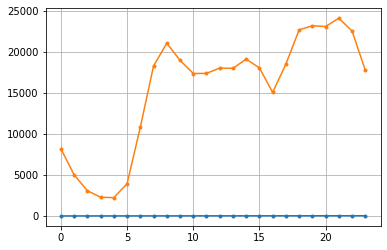

In [45]:
taxi_data = pd.read_csv('C:/Users/Asus/Desktop/SQL_Practice/exports/hourly_pickups_2016_06_01.csv')
taxi_plot = plt.plot(taxi_data, marker= ".")
plt.grid()
plt.show()

In [46]:
# When do taxi trips take the longest?
query = """
SELECT 
    DATE_PART('hour', tpep_pickup_datetime) AS trip_hour,
    PERCENTILE_CONT(.5)
        WITHIN GROUP (ORDER BY 
            tpep_dropoff_datetime - tpep_pickup_datetime) AS median_trip
FROM nyc_yellow_taxi_trips_2016_06_01
GROUP BY trip_hour
ORDER BY trip_hour;
"""

execute_query(conn, query)

,trip_hour,median_trip
0,0.0,0 days 00:10:04
1,1.0,0 days 00:09:27
2,2.0,0 days 00:08:59
3,3.0,0 days 00:09:57
4,4.0,0 days 00:10:06
5,5.0,0 days 00:07:37
6,6.0,0 days 00:07:54
7,7.0,0 days 00:10:23
8,8.0,0 days 00:12:28
9,9.0,0 days 00:13:11


For the next part of this chapter, data from the Amtrak website was used to create a table titiled "train_rides". For more information, please refer to the Practical SQL book documentation.

In [47]:
query = " SELECT * FROM train_rides;"

execute_query(conn, query)

,trip_id,segment,departure,arrival
0,1,Chicago to New York,2017-11-13 22:30:00-05:00,2017-11-14 18:23:00-05:00
1,2,New York to New Orleans,2017-11-15 14:15:00-05:00,2017-11-16 20:32:00-05:00
2,3,New Orleans to Los Angeles,2017-11-17 14:45:00-05:00,2017-11-18 12:00:00-05:00
3,4,Los Angeles to San Francisco,2017-11-19 13:10:00-05:00,2017-11-20 00:24:00-05:00
4,5,San Francisco to Denver,2017-11-20 12:10:00-05:00,2017-11-21 20:38:00-05:00
5,6,Denver to Chicago,2017-11-22 21:10:00-05:00,2017-11-23 15:50:00-05:00


In [48]:
# Calculating the length of each leg of the trip in our train_rides table
query = """
SELECT segment,
    TO_CHAR(departure, 'YYYY-MM-DD HH12:MI a.m. TZ') AS departure,
    arrival - departure AS segment_time
FROM train_rides;
"""

execute_query(conn, query)

,segment,departure,segment_time
0,Chicago to New York,2017-11-13 10:30 p.m. EST,0 days 19:53:00
1,New York to New Orleans,2017-11-15 02:15 p.m. EST,1 days 06:17:00
2,New Orleans to Los Angeles,2017-11-17 02:45 p.m. EST,0 days 21:15:00
3,Los Angeles to San Francisco,2017-11-19 01:10 p.m. EST,0 days 11:14:00
4,San Francisco to Denver,2017-11-20 12:10 p.m. EST,1 days 08:28:00
5,Denver to Chicago,2017-11-22 09:10 p.m. EST,0 days 18:40:00


In [49]:
# Calculating cumulative trip time
query = """
SELECT
    segment,
    arrival - departure AS segment_time,
    SUM(arrival - departure) OVER(ORDER BY trip_id) AS cumulative_time
FROM train_rides;
"""

execute_query(conn, query)

,segment,segment_time,cumulative_time
0,Chicago to New York,0 days 19:53:00,0 days 19:53:00
1,New York to New Orleans,1 days 06:17:00,2 days 02:10:00
2,New Orleans to Los Angeles,0 days 21:15:00,2 days 23:25:00
3,Los Angeles to San Francisco,0 days 11:14:00,3 days 10:39:00
4,San Francisco to Denver,1 days 08:28:00,4 days 19:07:00
5,Denver to Chicago,0 days 18:40:00,5 days 13:47:00


## Chapter 12: Advanced Query Techniques

In [50]:
# Filtering with subqueries in the WHERE clause - using a previously created US Counties table to calculate which U.S. counties are at the 90th percentile for population
query = """
SELECT geo_name,
    state_us_abbreviation,
    p0010001
FROM us_counties_2010
WHERE p0010001 >= (
    SELECT PERCENTILE_CONT(.9) WITHIN GROUP (ORDER BY p0010001)
    FROM us_counties_2010
)
ORDER BY p0010001 DESC;
"""

execute_query(conn, query)

,geo_name,state_us_abbreviation,p0010001
0,Los Angeles County,CA,9818605
1,Cook County,IL,5194675
2,Harris County,TX,4092459
3,Maricopa County,AZ,3817117
4,San Diego County,CA,3095313
...,...,...,...
310,St. Louis County,MN,200226
311,Mohave County,AZ,200186
312,Saginaw County,MI,200169
313,Elkhart County,IN,197559


In [51]:
# Creating derived tables with subqueries - here we use a derived subtable to figure out the mean and median of a population in one query
query = """
SELECT ROUND(calcs.average, 0) AS average,
    calcs.median,
    ROUND(calcs.average - calcs.median, 0) AS median_average_diff
FROM (
    SELECT avg(p0010001) AS average,
    CAST(PERCENTILE_CONT(0.5)
        WITHIN GROUP (ORDER BY p0010001) AS NUMERIC(10,1)) AS median
    FROM us_counties_2010
) AS calcs;
"""

execute_query(conn, query)

,average,median,median_average_diff
0,98233,25857.0,72376


In [52]:
# Joining derived tables - here we try to determine which states have the most meat, egg, and poultry processing plants per million population
query = """
SELECT census.state_us_abbreviation AS st,
    census.st_population,
    plants.plant_count,
    ROUND((plants.plant_count / CAST(census.st_population AS NUMERIC(10,1))) * 1000000, 1)
        AS plants_per_million
FROM (
    SELECT st,
        COUNT(*) as plant_count
    FROM meat_poultry_egg_inspect
    GROUP BY st
) AS plants
JOIN (
    SELECT state_us_abbreviation,
        SUM(p0010001) AS st_population
    FROM us_counties_2010
    GROUP BY state_us_abbreviation
) AS census
ON plants.st = census.state_us_abbreviation
ORDER BY plants_per_million DESC;
"""

execute_query(conn, query)

,st,st_population,plant_count,plants_per_million
0,NE,1826341,110,60.2
1,IA,3046355,149,48.9
2,VT,625741,27,43.1
3,HI,1360301,47,34.6
4,ND,672591,22,32.7
5,WI,5686986,185,32.5
6,MN,5303925,161,30.4
7,AR,2915918,87,29.8
8,SD,814180,24,29.5
9,PA,12702379,364,28.7


In [53]:
# Generating columns with subqueries - adding in the median of all counties to each row
query = """
SELECT geo_name,
    state_us_abbreviation AS st,
    p0010001 AS total_pop,
    (SELECT PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY p0010001)
        FROM us_counties_2010) AS us_median
FROM us_counties_2010;
"""

execute_query(conn, query)

,geo_name,st,total_pop,us_median
0,Autauga County,AL,54571,25857.0
1,Baldwin County,AL,182265,25857.0
2,Barbour County,AL,27457,25857.0
3,Bibb County,AL,22915,25857.0
4,Blount County,AL,57322,25857.0
...,...,...,...,...
3138,Sweetwater County,WY,43806,25857.0
3139,Teton County,WY,21294,25857.0
3140,Uinta County,WY,21118,25857.0
3141,Washakie County,WY,8533,25857.0


In [54]:
# Now we elaborate on the previous query to see the difference between each counties population and the median
query = """
SELECT geo_name,
    state_us_abbreviation AS st,
    p0010001 AS total_pop,
    (SELECT PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY p0010001)
        FROM us_counties_2010) AS us_median,
    p0010001 - (SELECT PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY P0010001) FROM us_counties_2010) AS diff_from_median
FROM us_counties_2010
WHERE (p0010001 - (SELECT PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY P0010001) FROM us_counties_2010))
    BETWEEN -1000 AND 1000;
"""

execute_query(conn, query)

,geo_name,st,total_pop,us_median,diff_from_median
0,Cherokee County,AL,25989,25857.0,132.0
1,Clarke County,AL,25833,25857.0,-24.0
2,Geneva County,AL,26790,25857.0,933.0
3,Cleburne County,AR,25970,25857.0,113.0
4,Johnson County,AR,25540,25857.0,-317.0
...,...,...,...,...,...
66,Lee County,VA,25587,25857.0,-270.0
67,Winchester city,VA,26203,25857.0,346.0
68,Mingo County,WV,26839,25857.0,982.0
69,Nicholas County,WV,26233,25857.0,376.0


Using subqueries as expressions to filter rows

Generating Values for the IN operator

    SELECT first_name, last_name
    FROM employees
    WHERE id IN (
        SELECT id
        FROM retirees
    );

Checking whether values exist

    SELECT first_name, last_name
    FROM employees
    WHERE EXISTS (
        SELECT id
        FROM retirees
    );

Or we could instead mimic the behavior of IN and limit names to where the subquery after EXISTS finds at least one corresponding id value in retirees.

    SELECT first_name, last_name
    FROM employees
    WHERE EXISTS(
        SELECT id
        FROM retirees
        WHERE id = employees.id
    )

**Common Table Expressions (CTE)** 

Another approach to creating temporary tables for querying. Informally called a "WITH" clause, this method defines one or more tables up front with subqueries that we can then query in the main query that follows.
CTE's help with the following things:
- Prestaging subsets of data to feed into a larger query for more complex analysis.
- CTE's make code more readable than performing subqueries.
- CTE's simplify queries with redundant code.

In [55]:
# A simple CTE based on our census data that determines how many counties in each state have 100k people or more
query = """
WITH
    large_counties (geo_name, st, p0010001)
AS (
    SELECT geo_name, state_us_abbreviation, p0010001
    FROM us_counties_2010
    WHERE p0010001 >= 100000
)
SELECT st, COUNT(*)
FROM large_counties
GROUP BY st
ORDER BY COUNT(*) DESC
LIMIT 5;
"""

execute_query(conn, query)

,st,count
0,TX,39
1,CA,35
2,FL,33
3,PA,31
4,NY,28


**Cross Tabulations**

Often called Pivot Tables or Crosstabs. just tables that compare sets of variables. 

First we must install the 'tablefunc' module by running the following query:

    'CREATE EXTENSION tablefunc;'

For the follwoing part of the chapter, a table titled 'ice_cream_survey' was created to practice Crosstabs. Please refer to the book documentation for more information.

In [56]:
# We can now use the crosstab function within the tablefunc() module to see how many people chose each flavor of ice cream in our ice_cream_survey table.
query = """
SELECT *
FROM CROSSTAB(
    'SELECT
        office,
        flavor,
        COUNT(*)
    FROM ice_cream_survey
    GROUP BY office, flavor
    ORDER BY office',

    'SELECT flavor
    FROM ice_cream_survey
    GROUP BY flavor
    ORDER BY flavor'
)
AS (office VARCHAR(20),
    chocolate BIGINT,
    strawberry BIGINT,
    vanilla BIGINT);
"""

execute_query(conn, query)

,office,chocolate,strawberry,vanilla
0,Downtown,23,32.0,19
1,Midtown,41,NaN,23
2,Uptown,22,17.0,23


For the next part of this chapter we will use a table titled, "temperature_readings", that uses data from the U.S. National Oceanic and Atmospheric Administration (NOAA). For more information, please refer to the book's documentation.

In [57]:
# Creating a Crosstab for our temperature_readings table to get median temperature for each month across three stations
query = """
SELECT *
FROM CROSSTAB(
    'SELECT station_name,
    DATE_PART(''month'', observation_date),
    PERCENTILE_CONT(0.5)
        WITHIN GROUP (ORDER BY max_temp)
    FROM temperature_readings
    GROUP BY station_name,
    DATE_PART(''month'', observation_date)
    ORDER BY station_name',

    'SELECT month
    FROM GENERATE_SERIES(1, 12) month')

AS (
    station VARCHAR(50),
    jan NUMERIC(3,0),
    feb NUMERIC(3,0),
    mar NUMERIC(3,0),
    apr NUMERIC(3,0),
    may NUMERIC(3,0),
    jun NUMERIC(3,0),
    jul NUMERIC(3,0),
    aug NUMERIC(3,0),
    sep NUMERIC(3,0),
    oct NUMERIC(3,0), 
    nov NUMERIC(3,0),
    dec NUMERIC(3,0)
    );
"""

execute_query(conn, query)

,station,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,CHICAGO NORTHERLY ISLAND IL US,34,36,46,50,66,77,81,80,77,65,57,35
1,SEATTLE BOEING FIELD WA US,50,54,56,64,66,71,76,77,69,62,55,42
2,WAIKIKI 717.2 HI US,83,84,84,86,87,87,88,87,87,86,84,82


In [58]:
# Reclassifying values with CASE
query = """
SELECT
    max_temp,
    CASE WHEN max_temp >= 90 THEN 'Hot'
        WHEN max_temp BETWEEN 70 AND 89 THEN 'Warm'
        WHEN max_temp BETWEEN 50 AND 69 THEN 'Pleasant'
        WHEN max_temp BETWEEN 33 AND 49 THEN 'Cold'
        WHEN max_temp BETWEEN 20 AND 32 THEN 'Freezing'
        ELSE 'Inhumane'
    END AS temperature_group
FROM temperature_readings;
"""

execute_query(conn, query)

,max_temp,temperature_group
0,31,Freezing
1,34,Cold
2,32,Freezing
3,32,Freezing
4,34,Cold
...,...,...
1072,47,Cold
1073,48,Cold
1074,48,Cold
1075,57,Pleasant


In [59]:
# Using CASE in a CTE to reclasssify the daily maximum temperatures forecast to generat a temps_collapsed CTE
query = """
WITH temps_collapsed (station_name, max_temperature_group) AS
    (SELECT
        station_name,
        CASE WHEN max_temp >= 90 THEN 'Hot'
        WHEN max_temp BETWEEN 70 AND 89 THEN 'Warm'
        WHEN max_temp BETWEEN 50 AND 69 THEN 'Pleasant'
        WHEN max_temp BETWEEN 33 AND 49 THEN 'Cold'
        WHEN max_temp BETWEEN 20 AND 32 THEN 'Freezing'
        ELSE 'Inhumane'
        END
    FROM temperature_readings)

SELECT station_name, max_temperature_group, COUNT(*)
FROM temps_collapsed
GROUP BY station_name, max_temperature_group
ORDER BY station_name, COUNT(*) DESC;
"""

execute_query(conn, query)

,station_name,max_temperature_group,count
0,CHICAGO NORTHERLY ISLAND IL US,Warm,133
1,CHICAGO NORTHERLY ISLAND IL US,Cold,92
2,CHICAGO NORTHERLY ISLAND IL US,Pleasant,91
3,CHICAGO NORTHERLY ISLAND IL US,Freezing,30
4,CHICAGO NORTHERLY ISLAND IL US,Inhumane,8
5,CHICAGO NORTHERLY ISLAND IL US,Hot,8
6,SEATTLE BOEING FIELD WA US,Pleasant,198
7,SEATTLE BOEING FIELD WA US,Warm,98
8,SEATTLE BOEING FIELD WA US,Cold,50
9,SEATTLE BOEING FIELD WA US,Hot,3


## Chapter 13: Mining Text To Find Meaningful Data

For this chapter two tables will be created, one based on crime reports from a sheriff's department near Washington D.C. and a set of State of the Union Adressses delivered by former presidents.

In [60]:
# Turning Text to Data with REGEX functions
query = "SELECT * FROM crime_reports;"

execute_query(conn, query)

,crime_id,date_1,date_2,street,city,crime_type,description,case_number,original_text
0,1,2017-04-16 21:00:00-04:00,2017-04-17 09:00:00-04:00,46000 Block Ashmere Sq.,Sterling,Larceny,The victim reported that a\r\nbicycle was stol...,C0170006614,4/16/17-4/17/17\r\n2100-0900 hrs.\r\n46000 Blo...
1,2,2017-04-08 16:00:00-04:00,NaT,46000 Block Potomac Run Plz.,Sterling,Destruction of Property,The victim\r\nreported that their vehicle was ...,C0170006162,4/8/17\r\n1600 hrs.\r\n46000 Block Potomac Run...
2,3,2017-04-04 14:00:00-04:00,2017-04-04 15:00:00-04:00,24000 Block Hawthorn Thicket Ter.,Sterling,Larceny,The complainant reported that\r\nmultiple wind...,C0170006079,4/4/17\r\n1400-1500 hrs.\r\n24000 Block Hawtho...
3,4,2017-04-10 16:05:00-04:00,NaT,21800 block Newlin Mill Rd.,Middleburg,Larceny,A license plate was reported\r\nstolen from a ...,SO170006250,04/10/17\r\n1605 hrs.\r\n21800 block Newlin Mi...
4,5,2017-04-09 12:00:00-04:00,NaT,470000 block Fairway Dr.,Sterling,Destruction of Property,Unknown\r\nsubject(s) wrote graffiti on a sign...,SO170006211,04/09/17\r\n1200 hrs.\r\n470000 block Fairway ...
5,6,2017-04-16 21:00:00-04:00,2017-04-17 09:00:00-04:00,46000 Block Ashmere Sq.,Sterling,Larceny,The victim reported that a\r\nbicycle was stol...,C0170006614,4/16/17-4/17/17\r\n2100-0900 hrs.\r\n46000 Blo...
6,8,2017-04-04 14:00:00-04:00,2017-04-04 15:00:00-04:00,24000 Block Hawthorn Thicket Ter.,Sterling,Larceny,The complainant reported that\r\nmultiple wind...,C0170006079,4/4/17\r\n1400-1500 hrs.\r\n24000 Block Hawtho...
7,7,2017-04-08 16:00:00-04:00,NaT,46000 Block Potomac Run Plz.,Sterling,Destruction of Property,The victim\r\nreported that their vehicle was ...,C0170006162,4/8/17\r\n1600 hrs.\r\n46000 Block Potomac Run...
8,9,2017-04-10 16:05:00-04:00,NaT,21800 block Newlin Mill Rd.,Middleburg,Larceny,A license plate was reported\r\nstolen from a ...,SO170006250,04/10/17\r\n1605 hrs.\r\n21800 block Newlin Mi...
9,10,2017-04-09 12:00:00-04:00,NaT,470000 block Fairway Dr.,Sterling,Destruction of Property,Unknown\r\nsubject(s) wrote graffiti on a sign...,SO170006211,04/09/17\r\n1200 hrs.\r\n470000 block Fairway ...


In [61]:
# Turning Text to Data with REGEX functions
query = """
SELECT crime_id,
    REGEXP_MATCH(original_text, '\d{1,2}\/\d{1,2}\/\d{2}')
FROM crime_reports;
"""

execute_query(conn, query)

,crime_id,regexp_match
0,1,[4/16/17]
1,2,[4/8/17]
2,3,[4/4/17]
3,4,[04/10/17]
4,5,[04/09/17]
5,6,[4/16/17]
6,8,[4/4/17]
7,7,[4/8/17]
8,9,[04/10/17]
9,10,[04/09/17]


In [62]:
# Using REGEX functions to capture instances where rows have more than one date
query = """
SELECT 
    crime_id,
    REGEXP_MATCHES(original_text, '\d{1,2}\/\d{1,2}\/\d{2}', 'g')
FROM crime_reports;
"""

execute_query(conn, query)

,crime_id,regexp_matches
0,1,[4/16/17]
1,1,[4/17/17]
2,2,[4/8/17]
3,3,[4/4/17]
4,4,[04/10/17]
5,5,[04/09/17]
6,6,[4/16/17]
7,6,[4/17/17]
8,8,[4/4/17]
9,7,[4/8/17]


In [63]:
# Using REGEX to match additional crime report elements - Here we match the first hour, second hour, and street
query = """
SELECT
    crime_id,
    REGEXP_MATCH(original_text,'\/\d{2}\r\n(\d{4})') AS first_hour,
    REGEXP_MATCH(original_text,'\d{2}\r\n\d{4}-(\d{4})') AS second_hour,
    REGEXP_MATCH(original_text,'hrs.\r\n(\d+ .+(?:Sq.|Plz.|Dr.|Ter.|Rd.))') AS street
FROM crime_reports;
"""

execute_query(conn, query)

,crime_id,first_hour,second_hour,street
0,1,[2100],[0900],[46000 Block Ashmere Sq.]
1,2,[1600],None,[46000 Block Potomac Run Plz.]
2,3,[1400],[1500],[24000 Block Hawthorn Thicket Ter.]
3,4,[1605],None,[21800 block Newlin Mill Rd.]
4,5,[1200],None,[470000 block Fairway Dr.]
5,6,[2100],[0900],[46000 Block Ashmere Sq.]
6,8,[1400],[1500],[24000 Block Hawthorn Thicket Ter.]
7,7,[1600],None,[46000 Block Potomac Run Plz.]
8,9,[1605],None,[21800 block Newlin Mill Rd.]
9,10,[1200],None,[470000 block Fairway Dr.]


In [64]:
# Using REGEX to match additional crime report elements - Here we match the case number, first date, crim type, and city
query = """
SELECT
    REGEXP_MATCH(original_text,'(?:C|SO)[0-9]+') AS case_number,
    REGEXP_MATCH(original_text,'\d{1,2}\/\d{1,2}\/\d{2}') AS date_1,
    REGEXP_MATCH(original_text,'\r\n(?:\w+ \w+|\w+)\r\n(.*):') AS crime_type,
    REGEXP_MATCH(original_text,'(?:Sq.|Plz.|Dr.|Ter.|Rd.)\r\n(\w+ \w+|\w+)\r\n') AS city
FROM crime_reports;
"""

execute_query(conn, query)

,case_number,date_1,crime_type,city
0,[C0170006614],[4/16/17],[Larceny],[Sterling]
1,[C0170006162],[4/8/17],[Destruction of Property],[Sterling]
2,[C0170006079],[4/4/17],[Larceny],[Sterling]
3,[SO170006250],[04/10/17],[Larceny],[Middleburg]
4,[SO170006211],[04/09/17],[Destruction of Property],[Sterling]
5,[C0170006614],[4/16/17],[Larceny],[Sterling]
6,[C0170006079],[4/4/17],[Larceny],[Sterling]
7,[C0170006162],[4/8/17],[Destruction of Property],[Sterling]
8,[SO170006250],[04/10/17],[Larceny],[Middleburg]
9,[SO170006211],[04/09/17],[Destruction of Property],[Sterling]


In [65]:
# Extracting text from the regexp_match() result
query = """
SELECT
    crime_id,
    (REGEXP_MATCH(original_text, '(?:C0|SO)[0-9]+'))[1]
        AS case_number
FROM crime_reports;
"""

execute_query(conn, query)

,crime_id,case_number
0,1,C0170006614
1,2,C0170006162
2,3,C0170006079
3,4,SO170006250
4,5,SO170006211
5,6,C0170006614
6,8,C0170006079
7,7,C0170006162
8,9,SO170006250
9,10,SO170006211


In [66]:
# Updating the crime_reports table with extracted data
query = """
UPDATE crime_reports
SET date_1 = 
(
    (REGEXP_MATCH(original_text, '\d{1,2}\/\d{1,2}\/\d{2}'))[1]
        ||' '||
    (REGEXP_MATCH(original_text, '\/\d{2}\r\n(\d{4})'))[1] 
        ||' US/Eastern'
)::TIMESTAMPTZ;

SELECT crime_id,
       date_1,
       original_text
FROM crime_reports;
"""

execute_query(conn, query)

,crime_id,date_1,original_text
0,1,2017-04-16 21:00:00-04:00,4/16/17-4/17/17\r\n2100-0900 hrs.\r\n46000 Blo...
1,2,2017-04-08 16:00:00-04:00,4/8/17\r\n1600 hrs.\r\n46000 Block Potomac Run...
2,3,2017-04-04 14:00:00-04:00,4/4/17\r\n1400-1500 hrs.\r\n24000 Block Hawtho...
3,4,2017-04-10 16:05:00-04:00,04/10/17\r\n1605 hrs.\r\n21800 block Newlin Mi...
4,5,2017-04-09 12:00:00-04:00,04/09/17\r\n1200 hrs.\r\n470000 block Fairway ...
5,6,2017-04-16 21:00:00-04:00,4/16/17-4/17/17\r\n2100-0900 hrs.\r\n46000 Blo...
6,8,2017-04-04 14:00:00-04:00,4/4/17\r\n1400-1500 hrs.\r\n24000 Block Hawtho...
7,7,2017-04-08 16:00:00-04:00,4/8/17\r\n1600 hrs.\r\n46000 Block Potomac Run...
8,9,2017-04-10 16:05:00-04:00,04/10/17\r\n1605 hrs.\r\n21800 block Newlin Mi...
9,10,2017-04-09 12:00:00-04:00,04/09/17\r\n1200 hrs.\r\n470000 block Fairway ...


In [67]:
# Using CASE to handle special instances
query = """
UPDATE crime_reports
SET date_1 =
(
    (REGEXP_MATCH(original_text, '\d{1,2}\/\d{1,2}\/\d{2}'))[1]
        ||' '||
    (REGEXP_MATCH(original_text, '\/\d{2}\r\n(\d{4})'))[1] 
        ||' US/Eastern'
)::TIMESTAMPTZ,

date_2 =
CASE
    WHEN (SELECT REGEXP_MATCH(original_text, '-(\d{1,2}\/\d{1,2}\/\d{1,2})') IS NULL)
                    AND (SELECT REGEXP_MATCH(original_text, '\/\d{2}\r\n\d{4}-(\d{4})') IS NOT NULL)
    THEN 
        ((REGEXP_MATCH(original_text, '\d{1,2}\/\d{1,2}\/\d{2}'))[1]
            || ' ' ||
        (REGEXP_MATCH(original_text, '\/\d{2}\r\n\d{4}-(\d{4})'))[1] 
            ||' US/Eastern'
        )::TIMESTAMPTZ 

    WHEN (SELECT REGEXP_MATCH(original_text, '-(\d{1,2}\/\d{1,2}\/\d{1,2})') IS NOT NULL)
            AND (SELECT REGEXP_MATCH(original_text, '\/\d{2}\r\n\d{4}-(\d{4})') IS NOT NULL)
    THEN 
        ((REGEXP_MATCH(original_text, '-(\d{1,2}\/\d{1,2}\/\d{1,2})'))[1]
            || ' ' ||
        (REGEXP_MATCH(original_text, '\/\d{2}\r\n\d{4}-(\d{4})'))[1] 
            ||' US/Eastern'
        )::TIMESTAMPTZ
    ELSE NULL 
END,
street = (REGEXP_MATCH(original_text, 'hrs.\r\n(\d+ .+(?:Sq.|Plz.|Dr.|Ter.|Rd.))'))[1],
city = (REGEXP_MATCH(original_text,
                        '(?:Sq.|Plz.|Dr.|Ter.|Rd.)\r\n(\w+ \w+|\w+)\r\n'))[1],
crime_type = (REGEXP_MATCH(original_text, '\r\n(?:\w+ \w+|\w+)\r\n(.*):'))[1],
description = (REGEXP_MATCH(original_text, ':\s(.+)(?:C0|SO)'))[1],
case_number = (REGEXP_MATCH(original_text, '(?:C0|SO)[0-9]+'))[1];

SELECT date_1,
    street,
    city,
    crime_type
FROM crime_reports;
"""

execute_query(conn, query)

,date_1,street,city,crime_type
0,2017-04-16 21:00:00-04:00,46000 Block Ashmere Sq.,Sterling,Larceny
1,2017-04-08 16:00:00-04:00,46000 Block Potomac Run Plz.,Sterling,Destruction of Property
2,2017-04-04 14:00:00-04:00,24000 Block Hawthorn Thicket Ter.,Sterling,Larceny
3,2017-04-10 16:05:00-04:00,21800 block Newlin Mill Rd.,Middleburg,Larceny
4,2017-04-09 12:00:00-04:00,470000 block Fairway Dr.,Sterling,Destruction of Property
5,2017-04-16 21:00:00-04:00,46000 Block Ashmere Sq.,Sterling,Larceny
6,2017-04-04 14:00:00-04:00,24000 Block Hawthorn Thicket Ter.,Sterling,Larceny
7,2017-04-08 16:00:00-04:00,46000 Block Potomac Run Plz.,Sterling,Destruction of Property
8,2017-04-10 16:05:00-04:00,21800 block Newlin Mill Rd.,Middleburg,Larceny
9,2017-04-09 12:00:00-04:00,470000 block Fairway Dr.,Sterling,Destruction of Property


In [26]:
# Using REGEX with WHERE()
query = """
SELECT geo_name
FROM us_counties_2010
WHERE geo_name ~* '(.+lade.+|.+lare.+)'
ORDER BY geo_name;
"""

execute_query(conn, query)

,geo_name
0,Bladen County
1,Clare County
2,Clarendon County
3,Glades County
4,Langlade County
5,Philadelphia County
6,Talladega County
7,Tulare County


In [27]:
# More examples of using REGEX with WHERE()
query = """
SELECT geo_name
FROM us_counties_2010
WHERE geo_name ~* '.+ash.+' AND geo_name !~ 'Wash.+'
ORDER BY geo_name;
"""

execute_query(conn, query)

,geo_name
0,Nash County
1,Wabash County
2,Wabash County
3,Wabasha County


In [28]:
# Examining text as lexemes with TO_TSVECTOR()
query = " SELECT TO_TSVECTOR('I am walking across the sitting room to sit with you.');"

execute_query(conn, query)

,to_tsvector
0,"'across':4 'room':7 'sit':6,9 'walk':3"


In [29]:
# Examining the TSQUERY() function
query = "SELECT TO_TSQUERY('walking & sitting')"

execute_query(conn, query)

,to_tsquery
0,'walk' & 'sit'


In [30]:
# Using the @@ match operator for searching
query = "SELECT TO_TSVECTOR('I am walking across the sitting room') @@ TO_TSQUERY('walking & sitting')"

execute_query(conn, query)

,?column?
0,True


For the next part of the chapter, a table titled, 'president_speeches, was created. Please refer to the books documentation for more information.

In [32]:
# Creating a table for full text search and looking at the results
query = "SELECT * FROM president_speeches LIMIT 5;"

execute_query(conn, query)

,sotu_id,president,title,speech_date,speech_text,search_speech_text
0,1,Harry S. Truman,Message to the Congress on the State of the Un...,1946-01-21,To the Congress of the United States:\r\nA qua...,None
1,2,Harry S. Truman,Annual Message to the Congress on the State of...,1947-01-06,"Mr. President, Mr. Speaker, Members of the Con...",None
2,3,Harry S. Truman,Annual Message to the Congress on the State of...,1948-01-07,"Mr. President, Mr. Speaker, and Members of the...",None
3,4,Harry S. Truman,Annual Message to the Congress on the State of...,1949-01-05,"Mr. President, Mr. Speaker, Members of the Con...",None
4,5,Harry S. Truman,Annual Message to the Congress on the State of...,1950-01-04,"Mr. President, Mr. Speaker, Members of the Con...",None


In [38]:
# Copying the contents of the speech text column to the search_speech_text column while converting it to a tsvector data type
query = """
UPDATE president_speeches
SET search_speech_text = TO_TSVECTOR('english', speech_text);

SELECT * FROM president_speeches LIMIT 5;
"""

execute_query(conn, query)

,sotu_id,president,title,speech_date,speech_text,search_speech_text
0,1,Harry S. Truman,Message to the Congress on the State of the Un...,1946-01-21,To the Congress of the United States:\r\nA qua...,'-11':16383 '-17':12335 '-1945':704 '-39':1261...
1,2,Harry S. Truman,Annual Message to the Congress on the State of...,1947-01-06,"Mr. President, Mr. Speaker, Members of the Con...","'-1948':4371 '000':2925,4952,5515,5588 '070':5..."
2,3,Harry S. Truman,Annual Message to the Congress on the State of...,1948-01-07,"Mr. President, Mr. Speaker, and Members of the...","'1':2360,4112,4743 '10':469,480,483,533,699,20..."
3,4,Harry S. Truman,Annual Message to the Congress on the State of...,1949-01-05,"Mr. President, Mr. Speaker, Members of the Con...","'1':2431 '16':73,3217 '1929':476 '1945':3203 '..."
4,5,Harry S. Truman,Annual Message to the Congress on the State of...,1950-01-04,"Mr. President, Mr. Speaker, Members of the Con...",'1930':1604 '1948':4316 '1949':3413 '1950':362...


In [39]:
# Searching speech text in the president_speeches table
query = """
SELECT president, speech_date
FROM president_speeches
WHERE search_speech_text @@ TO_TSQUERY('Vietnam')
ORDER BY speech_date;
"""

execute_query(conn, query)

,president,speech_date
0,John F. Kennedy,1961-05-25
1,Lyndon B. Johnson,1966-01-12
2,Lyndon B. Johnson,1967-01-10
3,Lyndon B. Johnson,1968-01-17
4,Lyndon B. Johnson,1969-01-14
5,Richard M. Nixon,1970-01-22
6,Richard M. Nixon,1972-01-20
7,Richard M. Nixon,1973-02-02
8,Gerald R. Ford,1975-01-15
9,Gerald R. Ford,1977-01-12


In [40]:
# Showing search result locations
query = """
SELECT president,
    speech_date,
    TS_HEADLINE(speech_text, TO_TSQUERY('Vietnam'),
                'StartSel = <,
                 StopSel = >,
                 MinWords = 5,
                 MaxWords = 7,
                 MaxFragments = 1')
FROM president_speeches
WHERE search_speech_text @@ TO_TSQUERY('Vietnam');
"""

execute_query(conn, query)

,president,speech_date,ts_headline
0,John F. Kennedy,1961-05-25,twelve months in <Vietnam> alone--by subversives
1,Lyndon B. Johnson,1966-01-12,bitter conflict in <Vietnam>. Later
2,Lyndon B. Johnson,1967-01-10,<Vietnam>--is not a simple one. There
3,Lyndon B. Johnson,1968-01-17,been held in <Vietnam>--in the midst
4,Lyndon B. Johnson,1969-01-14,"conflict in <Vietnam>, the dangers of nuclear"
5,Richard M. Nixon,1970-01-22,<Vietnam> in a way that our generation
6,Richard M. Nixon,1972-01-20,"<Vietnam> comes to an end, we must"
7,Richard M. Nixon,1973-02-02,have achieved in <Vietnam> has strengthened this
8,Gerald R. Ford,1975-01-15,"stress of the <Vietnam> war, legislative restr..."
9,Gerald R. Ford,1977-01-12,"world.\r\nThe <Vietnam> war, both materially"


In [43]:
# Using multiple search terms with TS_HEADLINE
query = """
SELECT president,
       speech_date,
       TS_HEADLINE(speech_text, TO_TSQUERY('transportation & !roads'),
                    'StartSel = <,
                     StopSel = >,
                     MinWords = 5,
                     MaxWords = 7,
                     MaxFragments = 1')
FROM president_speeches
WHERE search_speech_text @@ TO_TSQUERY('transportation & !roads');
"""

execute_query(conn, query)

,president,speech_date,ts_headline
0,Harry S. Truman,1947-01-06,"such industries as <transportation>, coal, oil..."
1,Harry S. Truman,1949-01-05,"field of <transportation>.\r\n\r\nFifth, to au..."
2,John F. Kennedy,1961-01-30,Obtaining additional air <transport> mobility-...
3,Lyndon B. Johnson,1964-01-08,reformed our tangled <transportation> and tran...
4,Lyndon B. Johnson,1967-01-10,"develop the <transportation>, communications, ..."
5,Richard M. Nixon,1971-01-22,"rural development, education, <transportation>..."
6,Richard M. Nixon,1972-01-20,education; to improve <transportation>
7,Gerald R. Ford,1976-01-19,urban <transportation> systems; develop more a...


In [44]:
# Searching for adjacent words
query = """
SELECT president,
       speech_date,
       TS_HEADLINE(speech_text, TO_TSQUERY('military <-> defense'),
                    'StartSel = <,
                     StopSel = >,
                     MinWords = 5,
                     MaxWords = 7,
                     MaxFragments = 1')
FROM president_speeches
WHERE search_speech_text @@ TO_TSQUERY('military <-> defense');
"""

execute_query(conn, query)

,president,speech_date,ts_headline
0,Dwight D. Eisenhower,1956-01-05,system our <military> <defenses> are designed
1,Dwight D. Eisenhower,1958-01-09,"direct <military> <defense> efforts, but likewise"
2,Dwight D. Eisenhower,1959-01-09,survival--the <military> <defense> of national...
3,Richard M. Nixon,1972-01-20,<defense> spending.\r\nStrong <military> <defe...


In [47]:
# Ranking queries by relevance
query = """
SELECT president,
       speech_text,
       CAST(TS_RANK(search_speech_text,
               TO_TSQUERY('war & security & threat & enemy'), 2) AS NUMERIC) AS score
FROM president_speeches
WHERE search_speech_text @@ TO_TSQUERY('war & security & threat & enemy')
ORDER BY score DESC
LIMIT 5;
"""

execute_query(conn, query)

,president,speech_text,score
0,Lyndon B. Johnson,"Mr. Speaker, Mr. President, Members of the Con...",0.0000728288
1,Dwight D. Eisenhower,To the Congress of the United States:\r\nI app...,0.0000633609
2,Richard M. Nixon,"Mr. Speaker, Mr. President, my colleagues in t...",0.0000497998
3,Harry S. Truman,"Mr. President, Mr. Speaker, Members of the Con...",0.0000365366
4,Dwight D. Eisenhower,"Mr. President, Mr. Speaker, Members of the 85t...",0.0000355315
